### Import all web scraping liberaries

In [9]:
import requests
from bs4 import BeautifulSoup

### Find number of pages

In [10]:
r = requests.get("https://www.otodom.pl/sprzedaz/mieszkanie/warszawa/?dist=0&subregion_id=197&city_id=26&order=filter_float_price%3Aasc&nrAdsPerPage=72&search%5Border%5D=filter_float_price%3Aasc")
soup = BeautifulSoup(r.content, "lxml")

number_of_pages = soup.find("strong", {"class":"current"}).text
number_of_pages = int(number_of_pages)
number_of_pages

683

### Scrape all inforamtion we need
####  *if you have problems with scraping or slow internet connection use included CSV file to load dataframe

In [42]:
l=[]
for page_number in range(1, number_of_pages + 1):
    base_url = f"https://www.otodom.pl/sprzedaz/mieszkanie/warszawa/?dist=0&subregion_id=197&city_id=26&order=filter_float_price%3Aasc&nrAdsPerPage=72&search%5Border%5D=filter_float_price%3Aasc&page="
    
    r = requests.get(base_url + str(page_number))
    soup = BeautifulSoup(r.content, "lxml")
    
    appartments = soup.find_all("div", {"class":"offer-item-details"})

    for appartment in appartments:
        
            area = appartment.find("li",{"class","offer-item-area"})
            location = appartment.find("p",{"class", "text-nowrap"})
            price= appartment.find("li",{"class", "offer-item-price"})
            rooms = appartment.find("li",{"class", "offer-item-rooms"})
            
            labels = ['Area', 'Location', 'Price', 'Rooms']
            attrs = [area, location, price, rooms]
            d ={}
            
            for attr, label in iter(zip(attrs, labels)):
                if attr:
                    d[label] = attr.text
                else:
                    d[label] = None

            l.append(d)

print(f'Scraped {len(l)} appartments data')

Scraped 45173 appartments data


### Import Pandas and Numpy liberaries

In [2]:
import pandas as pd
import numpy as np

### Create a dataframe with our scraped data

In [183]:
df = pd.DataFrame(l)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.head()

,Area,Location,Price,Rooms
0,31 m²,"Mieszkanie na sprzedaż: Warszawa, Wola",\n ...,2 pokoje
1,46 m²,"Mieszkanie na sprzedaż: Warszawa, Wola, Wolska",\n ...,2 pokoje
2,"50,88 m²",Mieszkanie na sprzedaż: Warszawa,\n ...,2 pokoje
3,"64,49 m²","Mieszkanie na sprzedaż: Warszawa, Wola, Wawrz...",\n ...,3 pokoje
4,"46,63 m²","Mieszkanie na sprzedaż: Warszawa, Targówek",\n ...,2 pokoje


### Or load from CSV
#### *I commented code so you don't load from CSV accidently
#### Includede CSV contains data scraped on 09.09.2017

In [56]:
#df = pd.read_csv('Warsaw_appartment_df', index_col=0)
#df.head(10)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27676 entries, 0 to 45023
Data columns (total 4 columns):
Area        27676 non-null object
Location    27676 non-null object
Price       27676 non-null object
Rooms       27676 non-null object
dtypes: object(4)
memory usage: 1.1+ MB


### Prepare data

In [58]:
df['Price'] = df['Price'].apply(lambda x: x.replace('\n','').replace(' ', '').replace('zł', '').replace('~', ''))
df['Price'] = df['Price'].apply(lambda x: x.replace(',', '.'))
df['Price'] = df['Price'].apply(lambda x: float(x))

In [59]:
df['Price'].head()

0    230000.0
1    306000.0
2    359661.0
3    542304.0
4    299000.0
Name: Price, dtype: float64

In [60]:
df['Rooms'] = df['Rooms'].apply(lambda x: x[0] if x[0] !='>' else 10)
df['Rooms'] = df['Rooms'].apply(lambda x: int(x))
df['Rooms'] = df['Rooms'].apply(lambda x: int(x))

In [61]:
df['Rooms'].head()

0    2
1    2
2    2
3    3
4    2
Name: Rooms, dtype: int64

In [62]:
df['Area'] = df['Area'].apply(lambda x: x.replace('m²',''))
df['Area'] = df['Area'].apply(lambda x: x.replace(',','.'))
df['Area'] = df['Area'].apply(lambda x: x.replace(' ',''))
df['Area'] = df['Area'].apply(lambda x: float(x))
df = df[df['Area'] < 300]

In [63]:
df['Area'].head(10)

0     31.00
1     46.00
2     50.88
3     64.49
4     46.63
5     46.00
6     54.00
7    163.26
8    133.77
9      1.00
Name: Area, dtype: float64

In [64]:
df['Location'] = df['Location'].apply(lambda x: x.replace('Mieszkanie na sprzedaż: ', ''))
df = df[df['Location'] != 'Warszawa']

### Functions to get Longitude and Latitude base on location

In [65]:
from time import sleep
from geopy.geocoders import GoogleV3

def locate(s):
    locator = GoogleV3(api_key='YOUR_GOOGLE_API_KEY', timeout=10)
    return locator.geocode(s)

In [66]:
# Little trick to save on request to geolocation API
# Just check unique locations and and then apply results to df :)
# I also separeted only locations to contain only districts since I only need districts locations for visualization

df['Location'] = df['Location'].apply(lambda x: ', '.join(x.split(',')[:2]))

In [67]:
df['Location'].nunique()

428

In [68]:
locations = df['Location'].unique()

In [44]:
d = {}

for location in locations:
    d[location] = locate(location)


{'Warszawa,   1 Sierpnia': Location(1 Sierpnia, Warszawa, Poland, (52.1927382, 20.9754866, 0.0)),
 'Warszawa,   Aleja Komisji Edukacji Narodowej 98': Location(Aleja Komisji Edukacji Narodowej 98, Warszawa, Poland, (52.1613313, 21.029845, 0.0)),
 'Warszawa,   Aleje Jerozolimskie': Location(Aleje Jerozolimskie, Poland, (52.1947951, 20.9262445, 0.0)),
 'Warszawa,   Biały Kamień': Location(Biały Kamień, Warszawa, Poland, (52.2060002, 20.9960858, 0.0)),
 'Warszawa,   Bluszczańska': Location(Bluszczańska, Warszawa, Poland, (52.2092363, 21.0639084, 0.0)),
 'Warszawa,   Egipska 6': Location(Egipska 6, Warszawa, Poland, (52.225912, 21.068903, 0.0)),
 'Warszawa,   Gioacchino Rossiniego': Location(Rossiniego, 01-001 Warszawa, Poland, (52.3434263, 21.0518419, 0.0)),
 'Warszawa,   Grunwaldzki': Location(plac Grunwaldzki, 01-787 Warszawa, Poland, (52.2623094, 20.9799711, 0.0)),
 'Warszawa,   Głębocka': Location(Głębocka, Warszawa, Poland, (52.3102751, 21.0620732, 0.0)),
 'Warszawa,   Herbu Szreniawa

In [87]:
#df['Location'] = df['Location'].map(d)
df.head()

,Area,Location,Price,Rooms
0,31.00,"(Wola, 05-077 Warsaw, Poland, (52.2333751, 20....",230000.0,2
1,46.00,"(Wola, 05-077 Warsaw, Poland, (52.2333751, 20....",306000.0,2
3,64.49,"(Wola, 05-077 Warsaw, Poland, (52.2333751, 20....",542304.0,3
4,46.63,"(Targówek, 01-001 Warsaw, Poland, (52.2823819,...",299000.0,2
5,46.00,"(Szmulowizna, 05-077 Warszawa, Poland, (52.258...",299000.0,3


In [90]:
df['Long'] = df['Location'].apply(lambda x: x.longitude if x else None)
df['Lat'] = df['Location'].apply(lambda x: x.latitude if x else None)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27456 entries, 0 to 45023
Data columns (total 6 columns):
Area        27456 non-null float64
Location    27448 non-null object
Price       27456 non-null float64
Rooms       27456 non-null int64
Long        27448 non-null float64
Lat         27448 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.7+ MB


In [93]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27448 entries, 0 to 45023
Data columns (total 6 columns):
Area        27448 non-null float64
Location    27448 non-null object
Price       27448 non-null float64
Rooms       27448 non-null int64
Long        27448 non-null float64
Lat         27448 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ MB


### If you coulnd follow the steps I give you processed df in csv :)
#### *It is dated to 09.09.2017

In [94]:
df = pd.read_csv('processed_df', index_col=0)

### Import all Data-Visualisation liberaries

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

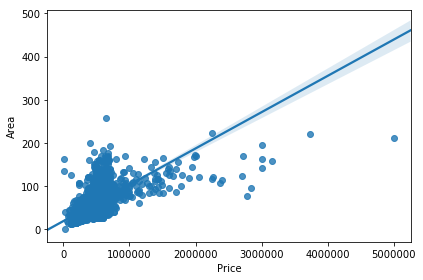

In [97]:
sns.regplot(x='Price', y='Area', data=df)
plt.tight_layout()